In [ ]:
from sqlalchemy import create_engine, MetaData
from airfare_packages import airfare_classes
from airfare_packages import airfare_visualization
from airfare_packages import airfare_modeling

engine = create_engine()

In [2]:
with airfare_classes.db_table("airfare_data_ml",engine,MetaData()) as table:
    airfare_ml_data = table.read_table()

In [3]:
training_data_x,training_data_y,validation_data_x,validation_data_y,testing_data_x,testing_data_y = airfare_modeling.split_scale_convert_data(airfare_ml_data,3,.2,["duration_minutes"])

In [4]:
training_model_results_dict = airfare_modeling.produce_forward_selection_lms(training_data_x,training_data_y,15,4,.95)

In [5]:
airfare_modeling.produce_ridge_regression_model(training_data_x,training_data_y,4,[0.0001, 0.001,0.01, 0.1, 1,4,6,7, 10],.95,training_model_results_dict)

In [6]:
airfare_modeling.produce_lasso_regression_model(training_data_x,training_data_y,4,[780001, 0.001,0.01, 0.1, 1,4,6,7, 10],.95,training_model_results_dict)

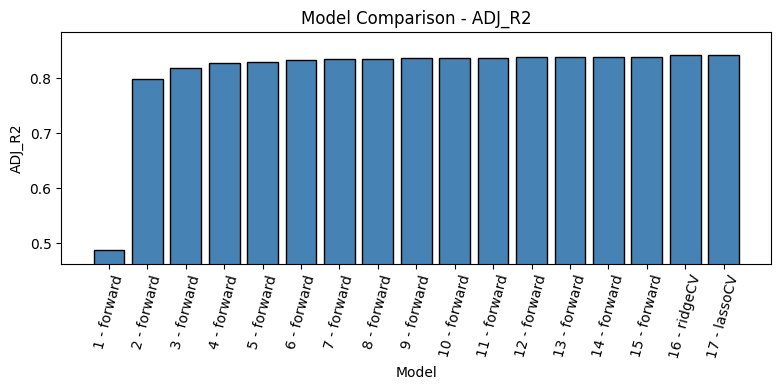

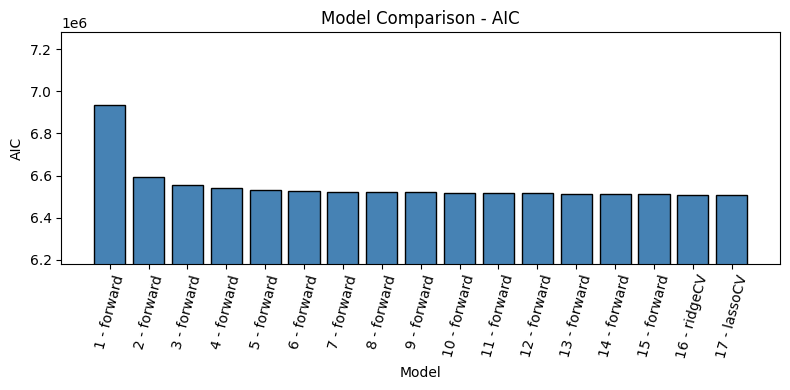

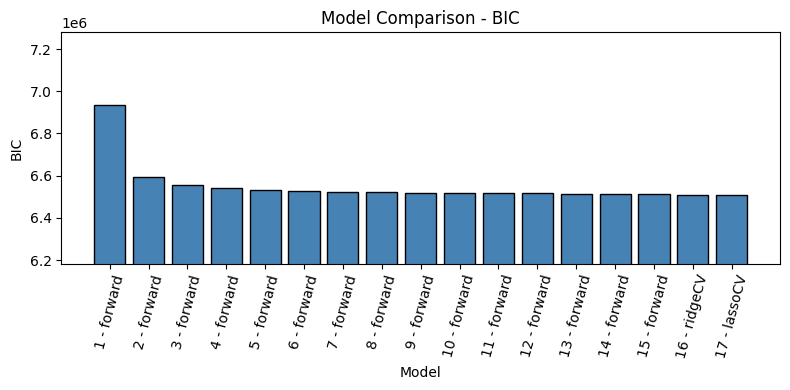

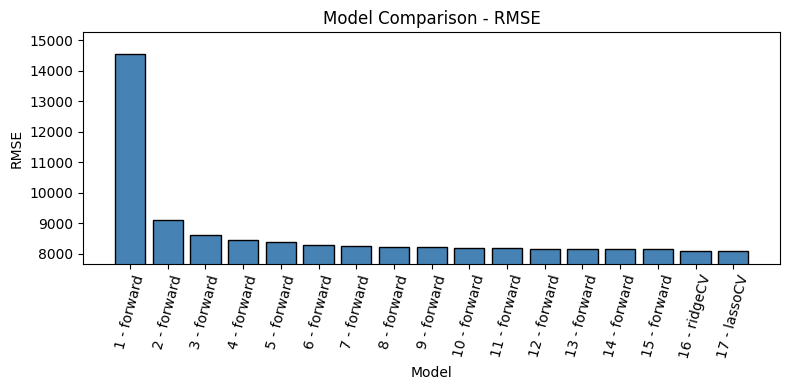

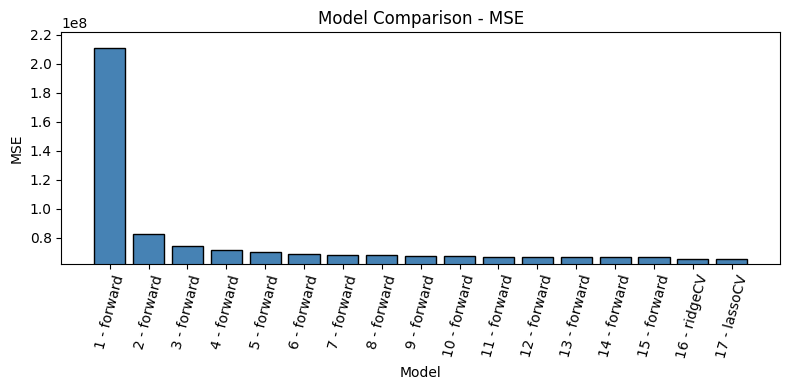

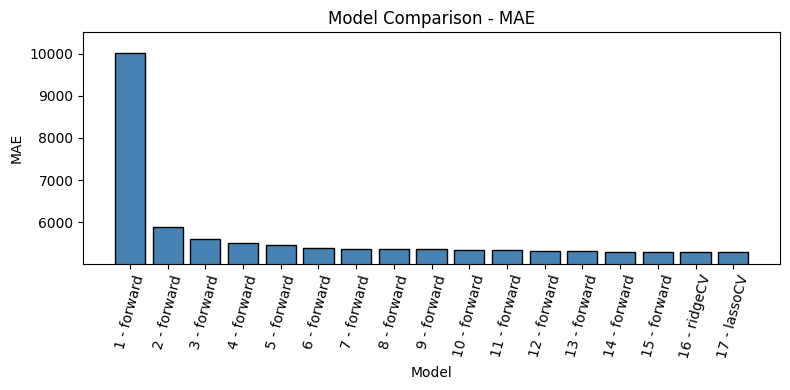

In [7]:
top_n_models = airfare_visualization.visualize_model_comparison_metrics(training_model_results_dict,4)

In [8]:
top_n_models



,model,adj_r2,aic,bic,mse,rmse,mae,adj_r2_rank,aic_rank,bic_rank,rmse_rank,mse_rank,mae_rank,avg_rank
16,17 - lassoCV,8.4154e-01,6.5083e+06,6.5088e+06,6.5321e+07,8.0821e+03,5.2891e+03,1.0000e+00,1.0000e+00,1.0000e+00,1.0000e+00,1.0000e+00,2.0000e+00,1.1700e+00
15,16 - ridgeCV,8.4154e-01,6.5083e+06,6.5088e+06,6.5321e+07,8.0821e+03,5.2890e+03,2.0000e+00,2.0000e+00,2.0000e+00,2.0000e+00,2.0000e+00,1.0000e+00,1.8300e+00
14,15 - forward,8.3907e-01,6.5138e+06,6.5140e+06,6.6342e+07,8.1450e+03,5.3039e+03,3.0000e+00,3.0000e+00,3.0000e+00,3.0000e+00,3.0000e+00,3.0000e+00,3.0000e+00
13,14 - forward,8.3884e-01,6.5143e+06,6.5145e+06,6.6437e+07,8.1509e+03,5.3073e+03,4.0000e+00,4.0000e+00,4.0000e+00,4.0000e+00,4.0000e+00,4.0000e+00,4.0000e+00


In [9]:
best_models_dict = airfare_modeling.return_best_models(top_n_models,training_model_results_dict)

In [10]:
model_predictions,validation_results_dict = airfare_modeling.best_model_validation(best_models_dict,validation_data_x,validation_data_y)

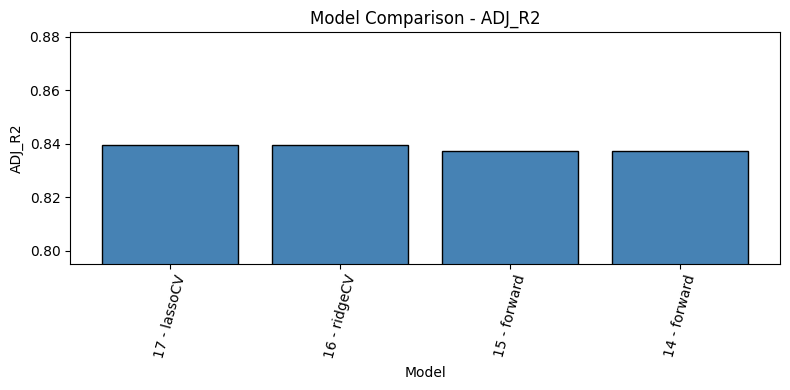

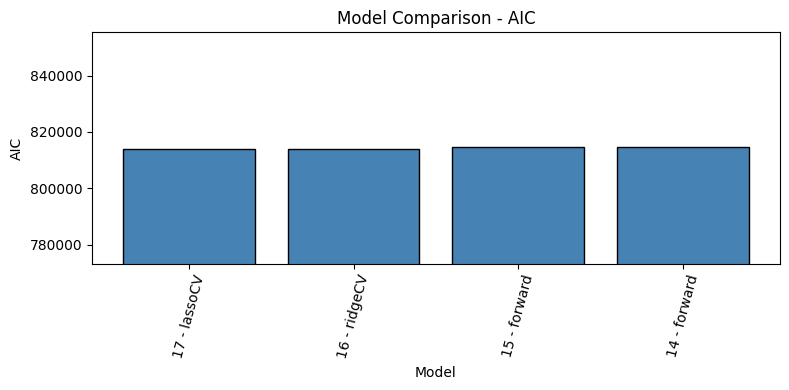

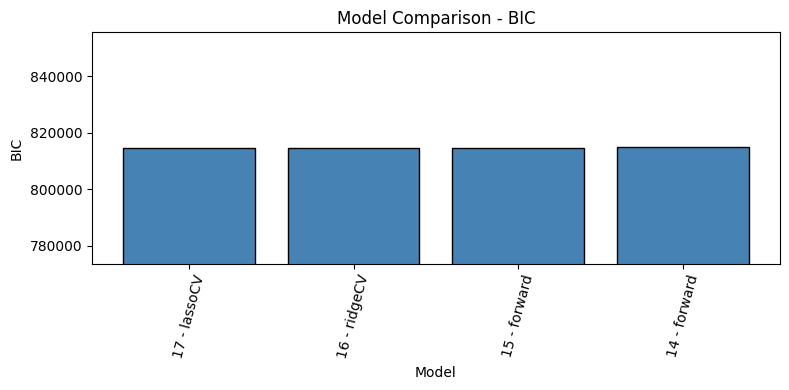

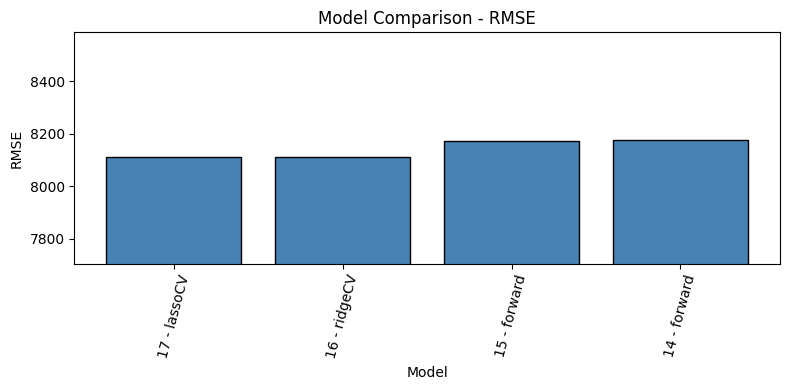

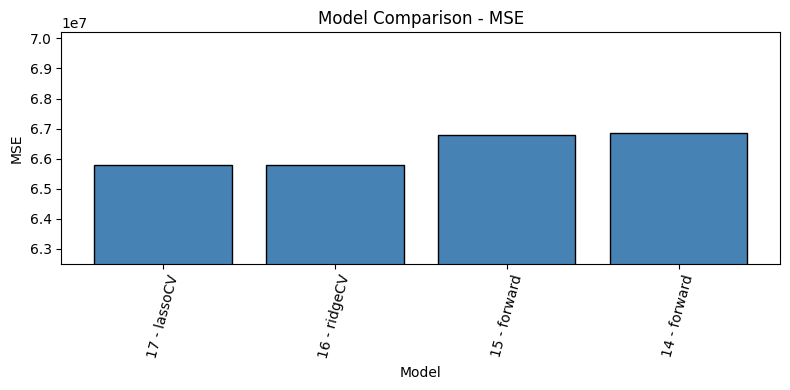

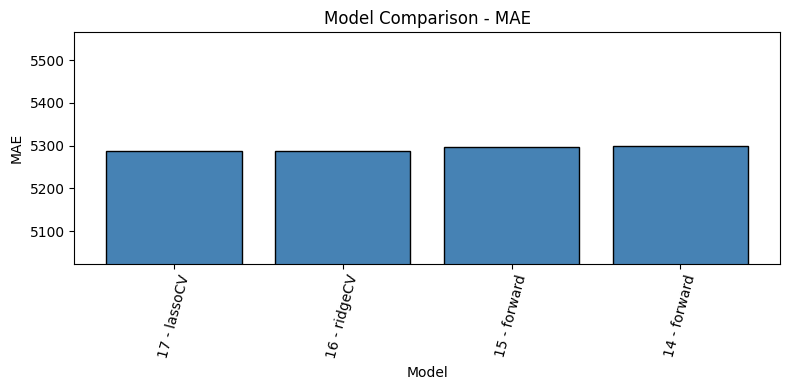

In [11]:
model_validation_table = airfare_visualization.visualize_model_comparison_metrics(validation_results_dict, 5)
final_model = model_validation_table.iloc[0]["model"]

In [12]:
model_validation_table

,model,mse,adj_r2,rmse,mae,aic,bic,adj_r2_rank,aic_rank,bic_rank,rmse_rank,mse_rank,mae_rank,avg_rank
1,16 - ridgeCV,6.5804e+07,8.3958e-01,8.1120e+03,5.2883e+03,8.1396e+05,8.1440e+05,1.0000e+00,1.0000e+00,1.0000e+00,1.0000e+00,1.0000e+00,1.0000e+00,1.0000e+00
0,17 - lassoCV,6.5804e+07,8.3958e-01,8.1120e+03,5.2884e+03,8.1396e+05,8.1440e+05,2.0000e+00,2.0000e+00,2.0000e+00,2.0000e+00,2.0000e+00,2.0000e+00,2.0000e+00
2,15 - forward,6.6788e+07,8.3731e-01,8.1724e+03,5.2976e+03,8.1456e+05,8.1470e+05,3.0000e+00,3.0000e+00,3.0000e+00,3.0000e+00,3.0000e+00,3.0000e+00,3.0000e+00
3,14 - forward,6.6859e+07,8.3714e-01,8.1767e+03,5.3003e+03,8.1461e+05,8.1474e+05,4.0000e+00,4.0000e+00,4.0000e+00,4.0000e+00,4.0000e+00,4.0000e+00,4.0000e+00


In [13]:
final_model_predictions_and_residual,final_model_metrics = airfare_modeling.final_model_validation(final_model,best_models_dict,testing_data_x,testing_data_y)

In [14]:
airfare_modeling.get_important_features(final_model,best_models_dict,5)

,feature,coefficient
10,class_ECONOMY,-4.0430e+04
12,class_PREMIUMECONOMY,-3.7711e+04
11,class_FIRST,1.7300e+04
1,connections,6.0258e+03
23,destination_city_Kolkata,4.5715e+03


In [15]:
final_model_metrics

defaultdict(dict,
            {'16 - ridgeCV': {'mse': 66208685.28679633,
              'adj_r2': 0.8404082004791891,
              'rmse': 8136.871959592109,
              'mae': 5306.901338261528,
              'aic': 814238.2387913167,
              'bic': 814674.1913643689}})

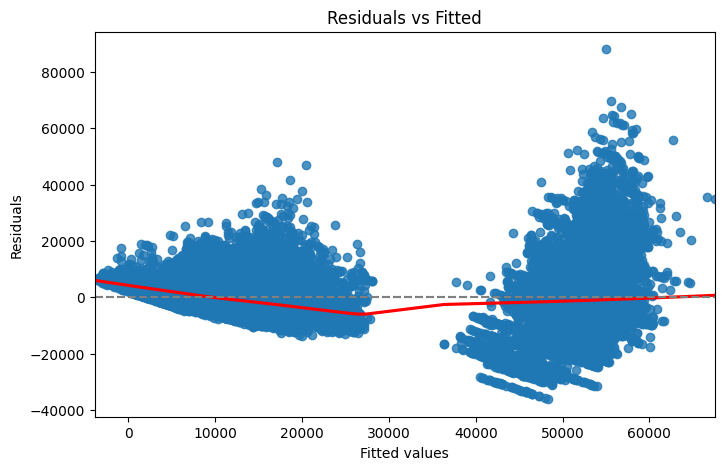

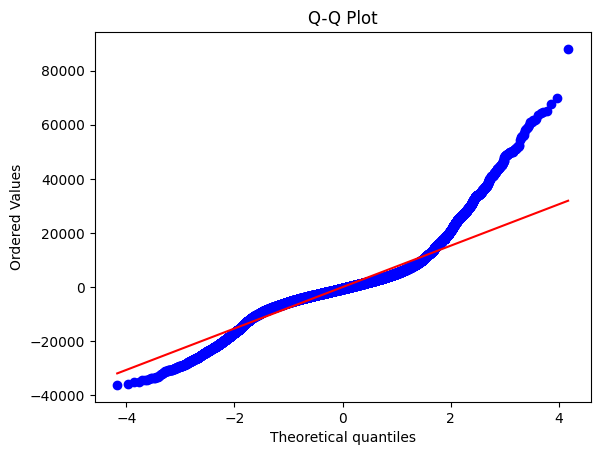

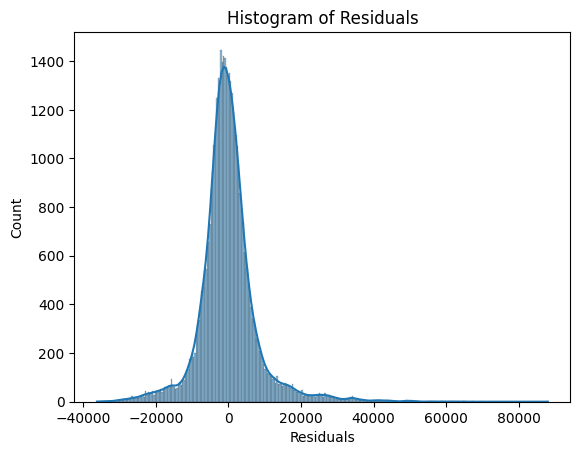

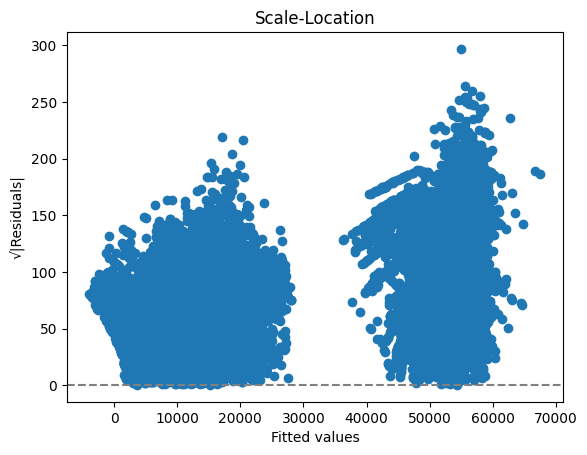

In [16]:
airfare_visualization.plot_linear_regression_diagnostics(final_model_predictions_and_residual["residual"],final_model_predictions_and_residual[final_model])